# Incremental Analysis

Here we analyse the outputs of the Transformers traiend for the TAPIR paper.

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns

from inceval.incoutputs import IncOutputs
from inceval.incdataset import IncData
from inceval.aux import GOLD, SILVER

In [2]:
#sns.set_theme()
sns.set_theme(style='white', font='Avenir Next Condensed')

# colors from https://coolors.co/
PALETTE = sns.color_palette(['#582C4D', '#A0A083', '#F38D68'])

Select the tasks we will report select one model for the qualitative evaluation:

In [3]:
TASKS = {
    'pos-ud-ewt': 'POS',
    'ner-conll2003': 'NER',
    'snips-slot': 'Slot'
}
MODELS = {
    'baseline': 'RI-Transformer',
    'lt_reviser': 'Tapir-LT',
    'trf_reviser': 'Tapir-Trf'
}
SELECTED_MODEL = 'Tapir-Trf'

TASK_ORDER = ['Slot', 'POS', 'NER']

EVAL_MODE = SILVER

In [4]:
edit_qualities = [
    'effective', 'defective', 'ineffective', 
    'convenient', 'inconvenient',
    'innovative', 'repetitive',
    'steady', 'recurrent',
    'oscillating', 'stable',
    'connected', 'disconnected',
    'accompanied', 'isolated',
    'short', 'long',
    'temporary', 'definite',
    'intermediate', 'final',
]

revision_qualities = [
    'effective', 'defective', 'ineffective', 
    'convenient', 'inconvenient',
    'steady', 'recurrent',
    'oscillating', 'stable',
    'isolated_edit', 'accompanied_edits',
    'connected_edits', 'disconnected_edits', 'dis_and_connected_edits',
    'short_range', 'long_range', 'short_and_long_range',
    'temporary', 'definite',
    'intermediate', 'final',
]

Load all results:

In [5]:
raw_data = {}
for model in ['baseline', 'lt_reviser', 'trf_reviser']:
    raw_data[MODELS[model]] = {} 
    directory = f'preprocessed/results_from_tapir/{model}/'
    
    for filename in os.listdir(directory):
        if 'train+valid' in filename:
            filepath = directory + filename
            task = "-".join(filename.replace('twopass_', '').split('_')[1:-1])
            if task in TASKS:
                with open(filepath, 'rb') as file:
                    raw_data[MODELS[model]][TASKS[task]] = pickle.load(file)
                print(f'Loaded model: {model} \t task:{task}')

Loaded model: baseline 	 task:ner-conll2003
Loaded model: baseline 	 task:snips-slot
Loaded model: baseline 	 task:pos-ud-ewt
Loaded model: lt_reviser 	 task:ner-conll2003
Loaded model: lt_reviser 	 task:pos-ud-ewt
Loaded model: lt_reviser 	 task:snips-slot
Loaded model: trf_reviser 	 task:snips-slot
Loaded model: trf_reviser 	 task:pos-ud-ewt
Loaded model: trf_reviser 	 task:ner-conll2003


In [6]:
raw_data['Tapir-LT']['NER'].keys()

dict_keys(['partial_outputs', 'log_changes', 'accuracy', 'monotonic_outputs', 'revision_outputs', 'input', 'token_idx', 'label_idx', 'gold_label'])

Construct the incremental output objects:

In [7]:
outputs = {}
dataset_outputs = {}

for model, tasks in raw_data.items():
    outputs[model] = {}
    dataset_outputs[model] = {}
    
    for task, outputs_raw in tasks.items():
        outputs[model][task] = {}
        
        for key, output_matrix in outputs_raw['partial_outputs'].items():
            n_tokens = output_matrix.shape[0]
            
            # for the baseline, all timesteps had recomputations
            recomputations = outputs_raw['revision_outputs'][key][0] if model != 'RI-Transformer' else np.ones(n_tokens)
            
            # the baseline does not have gold_labels, but according to the author the keys are the same
            # so we get the gold labels from tapir for all cases
            gold = raw_data['Tapir-LT'][task]['gold_label'][key][0]
            assert len(recomputations) == len(gold) and len(gold) == output_matrix.shape[0]
            
            inc_obj = IncOutputs(n_tokens, gold=gold, recomputations=recomputations, eval_mode=EVAL_MODE)
            inc_obj.add_all_prefixes(output_matrix)
            
            outputs[model][task][key] = inc_obj
            
        dataset_outputs[model][task] = IncData(outputs[model][task])

## Analysis on dataset level

### Metrics

In [8]:
METRICS = ['% recomputation', '% active recomputation', '% revision', 
           'R-pertinence', 'A-pertinence', 'R-appropriateness', 'A-appropriateness']

columns = ['model', 'task'] + METRICS
df_metrics = pd.DataFrame(columns=columns)

for model, model_data in dataset_outputs.items():
    for task, task_data in model_data.items():
        
        row = [
            model,
            task,
            task_data.perc_recomputations,
            task_data.perc_active_recomputations,
            task_data.perc_revisions,
            task_data.r_pertinence,
            task_data.a_pertinence,
            task_data.r_appropriateness,
            task_data.a_appropriateness
        ]
        df_metrics.loc[len(df_metrics)] = row

In [9]:
df_metrics

,model,task,% recomputation,% active recomputation,% revision,R-pertinence,A-pertinence,R-appropriateness,A-appropriateness
0,RI-Transformer,NER,100.000000,7.774712,7.774712,0.846964,0.926076,0.491316,0.986260
1,RI-Transformer,Slot,100.000000,21.230721,21.230721,0.942921,0.929870,0.783734,0.983724
2,RI-Transformer,POS,100.000000,19.299969,19.299969,0.916344,0.898798,0.684091,0.978225
3,Tapir-LT,NER,13.773333,20.234742,2.786998,0.870070,0.920046,0.237793,0.995968
4,Tapir-LT,POS,24.520742,39.554630,9.699089,0.907655,0.769261,0.297018,0.987270
5,Tapir-LT,Slot,20.349386,39.443155,8.026440,0.866667,0.910507,0.458031,0.987382
6,Tapir-Trf,Slot,21.419578,33.651727,7.208058,0.871179,0.919776,0.457569,0.989238
7,Tapir-Trf,POS,20.234915,34.090468,6.898177,0.937927,0.806371,0.264112,0.994329
8,Tapir-Trf,NER,10.367720,25.363825,2.629650,0.899180,0.914420,0.221036,0.997031


In [10]:
metric_cols = ['% recomputation', '% active recomputation', '% revision']
print(df_metrics.pivot(columns=['task'], index='model')[metric_cols].style.to_latex())

\begin{tabular}{lrrrrrrrrr}
{} & \multicolumn{3}{r}{% recomputation} & \multicolumn{3}{r}{% active recomputation} & \multicolumn{3}{r}{% revision} \\
{task} & {NER} & {POS} & {Slot} & {NER} & {POS} & {Slot} & {NER} & {POS} & {Slot} \\
{model} & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
RI-Transformer & 100.000000 & 100.000000 & 100.000000 & 7.774712 & 19.299969 & 21.230721 & 7.774712 & 19.299969 & 21.230721 \\
Tapir-LT & 13.773333 & 24.520742 & 20.349386 & 20.234742 & 39.554630 & 39.443155 & 2.786998 & 9.699089 & 8.026440 \\
Tapir-Trf & 10.367720 & 20.234915 & 21.419578 & 25.363825 & 34.090468 & 33.651727 & 2.629650 & 6.898177 & 7.208058 \\
\end{tabular}



Create matrices with the proportions of characteriscs:

In [11]:
columns = ['model', 'task'] + edit_qualities
df_edits = pd.DataFrame(columns=columns)

for model, model_data in dataset_outputs.items():
    for task, task_data in model_data.items():
        
        row = [task_data.perc_edits_with_quality(attr) for attr in edit_qualities]
        df_edits.loc[len(df_edits)] = [model, task] + row

In [12]:
columns = ['model', 'task'] + revision_qualities
df_revisions = pd.DataFrame(columns=columns)

for model, model_data in dataset_outputs.items():
    for task, task_data in model_data.items():
        
        row = [task_data.perc_revisions_with_quality(attr) for attr in revision_qualities]
        df_revisions.loc[len(df_revisions)] = [model, task] + row

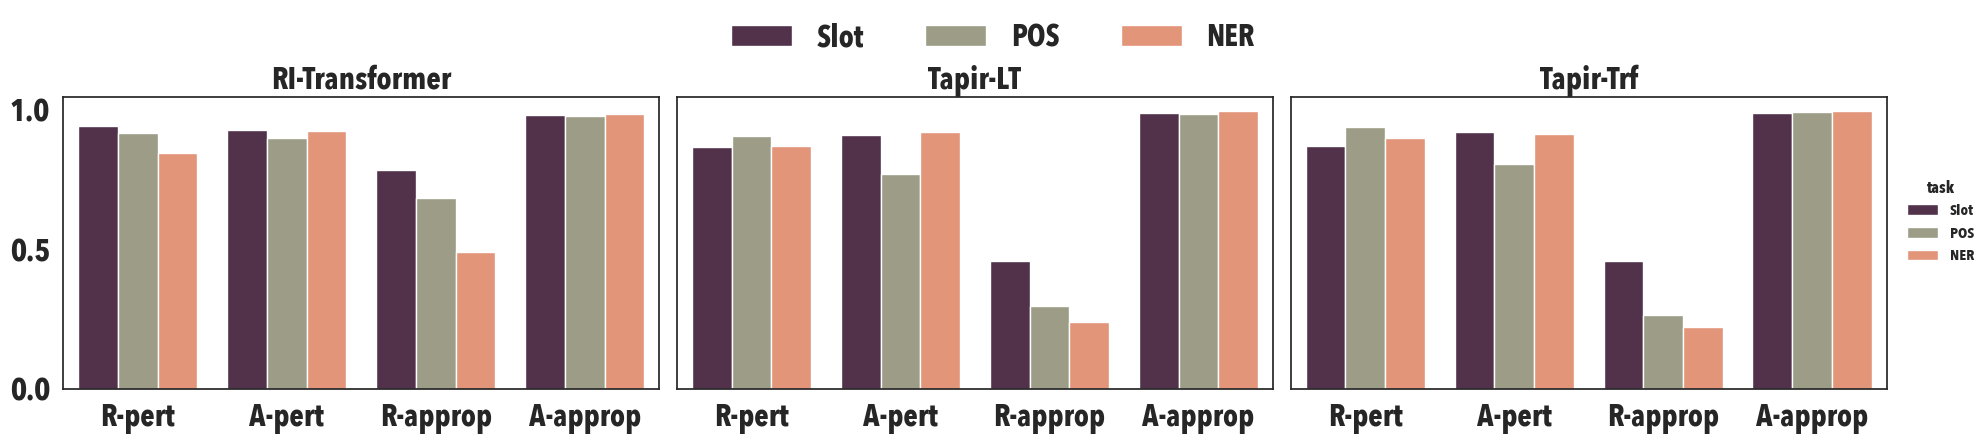

In [13]:
dfm = df_metrics.drop(columns=['% revision', '% recomputation', '% active recomputation']).melt(id_vars=['model', 'task'])

dfm['variable'] = dfm['variable'].str.replace('inence', '')
dfm['variable'] = dfm['variable'].str.replace('riateness', '')

g = sns.catplot(kind='bar',
                data=dfm,
                x='variable',
                y='value',
                hue='task',
                hue_order=TASK_ORDER,
                col='model', 
                height=4,
                aspect=1.6,
                palette=PALETTE)

g.set(xlabel=(''), ylabel=(''))
g.set_titles(template='{col_name}', size=22)

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelsize=22)

ax.legend(loc="upper center", ncol=3, bbox_to_anchor=(-0.5, 1.35), frameon=False, fontsize=22)
sns.despine(left=False, top=False, right=False)
plt.savefig('figures/metrics.pdf', bbox_inches='tight')
plt.show()

### Edits

In [14]:
chosen_cols = ['model', 'task', 'effective', 'convenient', 'innovative', 'steady', 'stable', 'connected',
               'accompanied', 'short', 'definite', 'final']

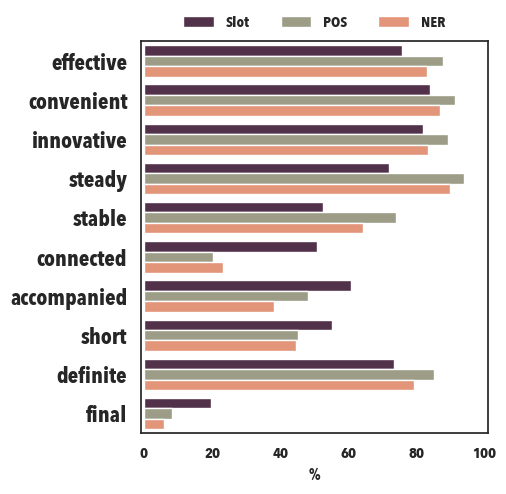

In [15]:
dfm = df_edits[df_edits['model'] == SELECTED_MODEL][chosen_cols].melt(id_vars=['model', 'task'])

g = sns.catplot(kind='bar',
                data=dfm,
                y='variable',
                x='value',
                hue='task',
                hue_order=TASK_ORDER,
                col='model',
                height=5,
                palette=PALETTE,
                legend_out=False)

g.set(xlabel=('%'), ylabel=(''), xlim=(-1,101), title='')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

ax.tick_params(axis='y', labelsize=16)
ax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1), frameon=False)
sns.despine(left=False, top=False, right=False)
plt.savefig('figures/edits.pdf', bbox_inches='tight')
plt.show()

### Revisions

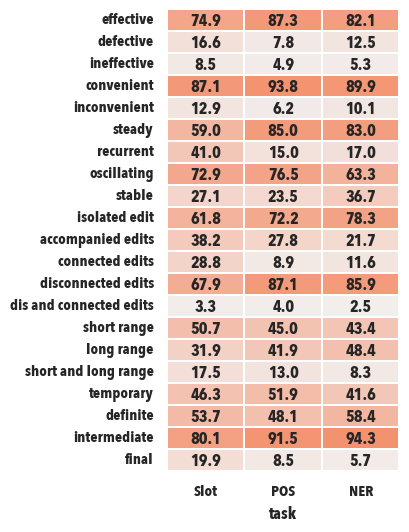

In [16]:
fig, ax = plt.subplots(figsize=(3, 6))

aux_d = df_revisions[df_revisions['model'] == SELECTED_MODEL].drop(columns=['model']).set_index('task')
aux_d = aux_d.rename({colname: colname.replace('_', ' ') for colname in aux_d.columns}, axis=1)

ax = sns.heatmap(aux_d.T,
                 vmin=0,
                 vmax=100,
                 annot=True,
                 fmt='.1f', 
                 linewidths=0.1,
                 #cmap=sns.cubehelix_palette(as_cmap=True), 
                 cmap=sns.light_palette("#F38D68", as_cmap=True),
                 cbar=False
                )

plt.savefig('figures/revision_types.pdf', bbox_inches='tight')
plt.show()

### Revision timesteps

In [17]:
rev_proportion = pd.DataFrame(columns=['model', 'task', '%_revisions'])
rev_time = pd.DataFrame(columns=['model', 'task', 'revision_%_time'])

for model, model_data in dataset_outputs.items():
    for task, task_data in model_data.items():
        
        # % of timesteps with revisions per sequence
        perc_revisions = [sent.perc_revisions for sent in task_data.instances.values()]
        for perc in perc_revisions:
            rev_proportion.loc[len(rev_proportion)] = [model, task, perc]
        
        # % of consumed tokens at revision per sequence
        # + 1 to have timesteps starting from 1 (= number of tokens consumed)
        perc_time = [100 * (np.array(seq.revision_timesteps) + 1) / seq.n_tokens for seq in task_data.instances.values()]
        for seq in perc_time:
            for perc in seq:
                rev_time.loc[len(rev_time)] = [model, task, perc]

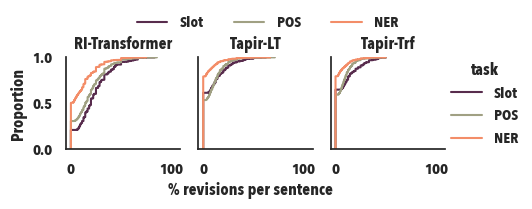

In [18]:
g = sns.FacetGrid(rev_proportion,
                  col='model',
                  hue='task',
                  hue_order=TASK_ORDER,
                  palette=PALETTE,
                  height=2,
                  aspect=0.8)
g.map_dataframe(sns.ecdfplot, x='%_revisions')
g.add_legend()
g.set_titles(template='{col_name}')
g.set(xlim=(-5, 109), xlabel='')
plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(-0.55, 1.6), frameon=False)
plt.suptitle('% revisions per sentence', y=0.18, fontsize=12)
plt.savefig('figures/revisions_per_sentence.pdf', bbox_inches='tight')
plt.show()

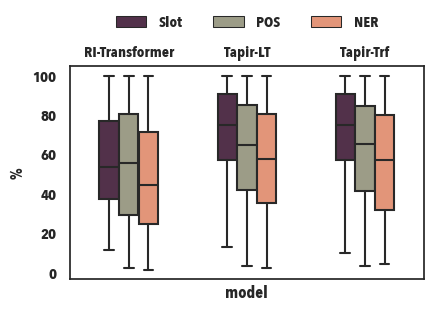

In [19]:
g = sns.catplot(data=rev_time,
                y='revision_%_time',
                x='model',
                hue='task',
                hue_order=TASK_ORDER,
                kind='box',
                legend_out=False,
                palette=PALETTE,
                height=3,
                aspect=1.5,
                width=0.5)
#g.set(ylabel='% time steps (tokens)\nconsumed at revisions')
g.set(ylabel='%')
for ax in g.axes.flatten():
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none') 
    ax.tick_params(axis='x', pad=-2)
    
plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.3), frameon=False)
sns.despine(left=False, top=False, right=False)
plt.savefig('figures/revision_time.pdf', bbox_inches='tight')
plt.show()